In [ ]:
# "Spherical clustering of DCSBM graph embeddings"
> "Exploring the use of spherical clustering for DCSBM estimation"
- toc: true
- badges: true
- comments: true
- categories: [DCSBM, spherical clustering, graspologic]
- hide: false
- search_exclude: false
- author: < Giorgio Di Salvo >

# Spherical clustering of DCSBM

This Notebook attempts to compare the ARIs obtained by fitting Gaussian mixture models(GMM) to the latent positions obtained from Adjacency spectral embedding of DCSBM graphs versus fitting GMM to the same latent positions but expressed in spherical coordinates as described by [Passino et al.](https://arxiv.org/pdf/2011.04558.pdf). 


Synthetic data will be simulated by sampling undirected graphs from degree-corrected stochastic blockmodels(DCSBM) with a fixed number of communities $K=3$.

### Import

Let's first import relevant packages

In [ ]:
# collapse
#! /usr/bin/env python3
import numpy as np
from numpy.random import normal, poisson
import argparse
from collections import Counter
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import eigsh
from sklearn.preprocessing import scale
from scipy.stats import chi2, norm
from sklearn.metrics import adjusted_rand_score as ari
!pip install graspologic
import graspologic
from graspologic.simulations import sbm
from graspologic.embed import AdjacencySpectralEmbed
from graspologic.cluster import AutoGMMCluster
from sklearn.preprocessing import normalize
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.special import gamma, factorial

## Function converting cartesian to spherical coordinates

Let's now define a function to perform the transformation of coordinates.

In [ ]:
# collapse
#Code provided by Passino et al.
## Takes a vector and returns its spherical coordinates
def cart_to_sphere(x):
    ## theta_1
    q = np.arccos(x[1] / np.linalg.norm(x[:2]))
    sphere_coord = [q] if x[0] >= 0 else [2*np.pi - q]
    ## Loop for theta_2, ..., theta_m-1
    for j in range(2,len(x)):
      sphere_coord += [2 * np.arccos(x[j] / np.linalg.norm(x[:(j+1)]))]
    ## Return the result in a numpy array
    return np.array(sphere_coord)

## Takes a matrix and returns the spherical coordinates obtained along the given axis
def theta_transform(X,axis=1):
    ## Apply the function theta_transform along the axis
    return np.apply_along_axis(func1d=cart_to_sphere, axis=axis, arr=X)

# Function used for ARIs comparison and plotting

Let's now define a function to compare ARIs, which will be handy for experiments.

In [ ]:
# collapse
def plot_latent(X, zz, method = None, pred = False, scale=4):
  fig, ax = plt.subplots(1, X.shape[1], figsize=(scale * X.shape[1], scale * 1))
  if method == 'theta':
    indices = [(i, i+1) if i != 1 else (i-(X.shape[1]-1),i)for i in range(X.shape[1])]
    variable_name = "\Theta"
    msg = "spherical coordinates on unit circle"
  elif method == 'normalised':
    indices = [(i, i+1) if i != 2 else (i-(X.shape[1]-1),i)for i in range(X.shape[1])]
    variable_name = "\overline{X}"
    msg = "projections on unit circle"
  else:
    indices = [(i, i+1) if i != 2 else (i-(X.shape[1]-1),i)for i in range(X.shape[1])]
    variable_name = "X"
    msg = "no transformation"

  legend = ["Community "+str(z+1) for z in zz]

  for i in range(X.shape[1]):
        xlabel = r"$\mathbf{" + variable_name + "}_"+str(indices[i][0]) + "$"
        ylabel = r"$\mathbf{" + variable_name + "}_"+str(indices[i][1]) + "$"

        x_hist = {xlabel: X[:, indices[i][0]], ylabel: X[:, indices[i][1]], 'labels': legend}

        x_hist = pd.DataFrame(data=x_hist)
        sns.scatterplot(data=x_hist, x=xlabel,y = ylabel, hue="labels", palette= "tab10", ax = ax[i], edgecolors=None, linewidth=0, alpha = 0.7, s=10)
        ax[i].set(xlabel=xlabel, ylabel=ylabel)
        ax[i].axis('equal')
        if i == X.shape[1]-1:
          ax[i].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
        else:
          ax[i].get_legend().remove()
  fig.subplots_adjust(hspace=10)
  if pred:
    fig.suptitle(r"GMM predictions on Latent Positions using "+msg)
  else:
    fig.suptitle(r"Latent Positions using "+msg)

def plot_beta(ax, a, b):
  def beta_pdf(x,a,b):
    return ((gamma(a+b))/(gamma(a)*gamma(b)))*(x**(a-1))*((1-x)**(b-1))
  x = np.array(range(0,101))/100
  beta_pdf = np.apply_along_axis(lambda inp: beta_pdf(inp, a, b), axis=0, arr=x)
  ax.plot(x, beta_pdf)
  ax.set(xlabel='Value', ylabel='Probability', title='Degree correction parameters pdf')
def plot_hist_dc(rho, ax):
  ax.hist(x=rho, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
  ax.set(xlabel='Value', ylabel='Frequency', title='Degree correction parameters histogram')

def compare_ARIs(B, n = 1000, M_sim = 25, K = 3, beta_params = (2,1), seed = 14441, plot = True, check_lcc = False):
  ## Set seed to repeat the simulation
  np.random.seed(seed)
  q = np.array([int(x) for x in np.linspace(0,n,num=K,endpoint=False)])
  z = np.zeros(n,dtype=int)
  for k in range(K):
      z[q[k]:] = k
  
  n_com_1000 = []
  n_com_norm_1000 = []
  n_com_theta_1000 = []

  ari_com_1000 = []
  ari_com_norm_1000 = []
  ari_com_theta_1000 = []

  if plot:
    scale = 4
    fig1, axis1 = plt.subplots(1, 2, figsize=(scale * 2, scale * 1))
    fig1.tight_layout(pad=5.0)

    plot_beta(axis1[0], a=beta_params[0],b=beta_params[1])

    rho = np.random.beta(a=beta_params[0],b=beta_params[1],size=n)
    plot_hist_dc(rho, axis1[1])


  ## Repeat M_sim times
  for s in range(M_sim):
      print(s)
      rho = np.random.beta(a=beta_params[0],b=beta_params[1],size=n)
      if s==0 and plot:
        plot_hist_dc(rho, axis1[1])

      ## Construct the adjacency matrix
      A = np.zeros((n,n))
      for i in range(n-1):
          for j in range(i+1,n):
              edge = np.random.binomial(n=1,p=rho[i]*rho[j]*B[z[i],z[j]],size=1)
              A[i,j] = edge
              A[j,i] = edge
      
      ## Obtain the embeddings
      ase = AdjacencySpectralEmbed(n_components=K, check_lcc=check_lcc)
      X = ase.fit_transform(A)

      #removes latent positions made up only by zeros
      idx_zerorows = np.where(~X.any(axis=1))
      X = np.delete(X, idx_zerorows, 0) #removes latent positions made up only by zeros
      zz = np.delete(z, idx_zerorows, 0) 

      if s ==0 and plot:
        plot_latent(X, zz, method = None, pred = False)

      #M = AutoGMMCluster(min_components=2, max_components=7, affinity= 'euclidean', linkage='ward', covariance_type='full')
      M = AutoGMMCluster(min_components=2, max_components=7)
      for t in [None, 'normalised', 'theta']:
        if t == 'normalised':
            X_norm = normalize(X)
            if s ==0 and plot:
              plot_latent(X_norm, zz, method = t, pred = False)
            M.fit(X_norm, y=zz)
            if s ==0 and plot:
              zz_hat = M.model_.predict(X_norm) # Incorporate zz_hat into plot_latent
              plot_latent(X_norm, zz_hat, method = t, pred = True)
            n_com_norm_1000.append(M.n_components_)
            ari_com_norm_1000.append(M.ari_)
        elif t == 'theta':
            X_theta = theta_transform(X)
            if s ==0 and plot:
              plot_latent(X_theta, zz, method = t, pred = False)
            M.fit(X_theta, y=zz)
            if s ==0 and plot:
              zz_hat = M.model_.predict(X_theta)
              plot_latent(X_theta, zz_hat, method = t, pred = True)
            n_com_theta_1000.append(M.n_components_)
            ari_com_theta_1000.append(M.ari_)
        else:
            M.fit(X, y=zz)
            if s ==0 and plot:
              zz_hat = M.model_.predict(X)
              plot_latent(X, zz_hat, method = t, pred = True)
            n_com_1000.append(M.n_components_)
            ari_com_1000.append(M.ari_)

  return ([n_com_1000, n_com_norm_1000, n_com_theta_1000], [ari_com_1000, ari_com_norm_1000, ari_com_theta_1000])

# Visual intuition

Let's first develop a simple visual intuition.

Here we simulate a graph $G\sim DCSBM$ with the following parameters:

$n = 500\\
K=2\\
\rho_{i}\sim Beta(2,1)\\
B = \begin{bmatrix}0.1 & 0.05\\
0.05 & 0.15 \end{bmatrix}$

We then perform Adjacency Spectral Embedding to obtain the latent positions $X$. We will also compute $\bar X$ as the normalized latent positions for $X$ and $\Theta$ as representation of $X$ in spherical coordinates on the unit sphere. 

Finally we plot the histograms for $X$,$\bar X$, and $\Theta$.

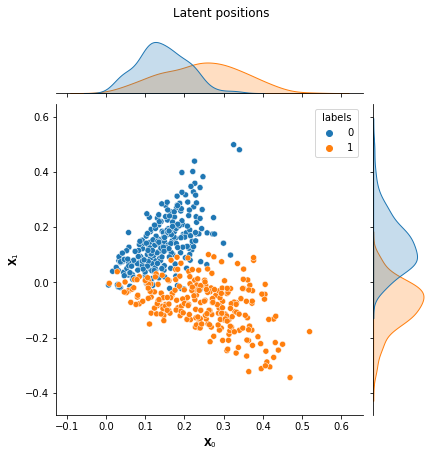

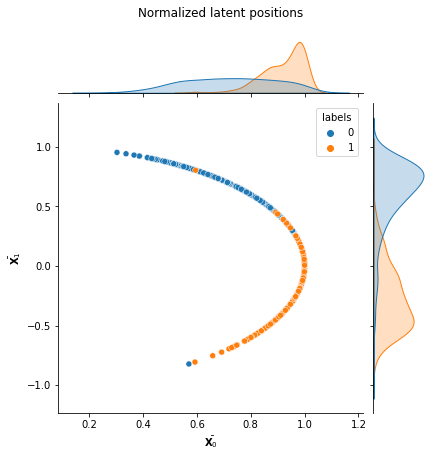

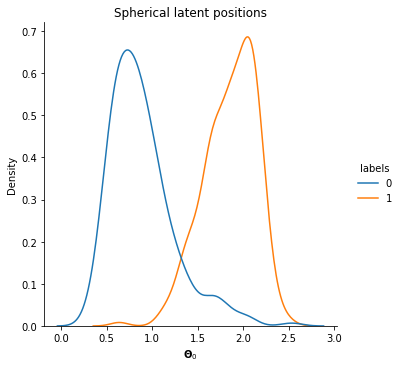

In [ ]:
# collapse
K = 2
n = 500

## Set seed to repeat the simulation
np.random.seed(14441)
q = np.array([int(x) for x in np.linspace(0,n,num=K,endpoint=False)])
z = np.zeros(n,dtype=int)
for k in range(K):
    z[q[k]:] = k

B = np.vstack(([0.1,0.05],[0.05,0.15]))

rho = np.random.beta(a=2,b=1,size=n)
## Construct the adjacency matrix
A = np.zeros((n,n))
for i in range(n-1):
    for j in range(i+1,n):
        edge = np.random.binomial(n=1,p=rho[i]*rho[j]*B[z[i],z[j]],size=1)
        A[i,j] = edge
        A[j,i] = edge

## Obtain the embeddings
ase = AdjacencySpectralEmbed(n_components=K, check_lcc=False)
X = ase.fit_transform(A)

#removes latent positions made up only by zeros
idx_zerorows = np.where(~X.any(axis=1))
X = np.delete(X, idx_zerorows, 0) #removes latent positions made up only by zeros
zz = np.delete(z, idx_zerorows, 0) 

for t in [None, 'normalised', 'theta']:
  if t == 'normalised':
      x_hist = {r"$\bar{\mathbf{X}_0}$": normalize(X)[:, 0],r"$\bar{\mathbf{X}_1}$": normalize(X)[:, 1], 'labels': zz}
      x_hist = pd.DataFrame(data=x_hist)
      sns.jointplot(data=x_hist, x=r"$\bar{\mathbf{X}_0}$", y=r"$\bar{\mathbf{X}_1}$", hue="labels")
      plt.suptitle("Normalized latent positions", y = 1.05)
  elif t == 'theta':
      x_hist = {r"$\mathbf{\Theta}_0$": theta_transform(X)[:, 0], 'labels': zz}
      x_hist = pd.DataFrame(data=x_hist)
      sns.displot(data=x_hist, x=r"$\mathbf{\Theta}_0$", hue="labels",  kind="kde")
      plt.title("Spherical latent positions")
  else:
      x_hist = {r"$\mathbf{X}_0$": X[:, 0],r"$\mathbf{X}_1$": X[:, 1], 'labels': zz}
      x_hist = pd.DataFrame(data=x_hist)
      sns.jointplot(data=x_hist, x=r"$\mathbf{X}_0$", y=r"$\mathbf{X}_1$", hue="labels")
      plt.suptitle("Latent positions", y = 1.05) 

Looking at the histograms of the latent positions $X$ and the normalized latent position $\bar X$ we notice that there is little separation for the two communities in at least one of the two embedding dimensions. 

On the other hand, looking at the representations in spherical coordinates $\Theta$ we notice that the two communities appear to be more distinct. Thus, the basic idea behind clustering in spherical coordinates is to exploit such greater separation between the distributions in the new coordinate frame. 

Note: Since the spherical coordinates are relative to projections on the unit sphere, the representation of latent positions will be one dimensional in this case and in general one dimension lower than the dimensionality of the other embeddings method.

# ARI comparison for $n=500$ number of nodes

We now simulate $N=50$ undirected graphs from degree-corrected stochastic blockmodels(DCSBM) with a fixed number of communities $K=3$. Each graph has $n=500$ nodes and is simulated by randomly selecting $B \sim Uniform(0, 1)^{K×K}$ and sampling the degree correction parameters
$\rho \sim Beta(2, 1)$.

We then compute the embedding $X$, the row-normalized embedding $\bar X$ and the spherical coordinates representation of the embedding $\Theta$ on the unit sphere.

$N = 50,K=3\\
| G_i | = 500\\
G_i \sim DCSBM(B_i, \rho) \text{for }i= 1,2,...,N \\
B_i \sim Uniform(0, 1)^{K×K}\\
\rho \sim Beta(2, 1)$

In [ ]:
# collapse
## Arguments
n = 500
M_sim = 50

K = 3

## Set seed to repeat the simulation
np.random.seed(14441)
q = np.array([int(x) for x in np.linspace(0,n,num=K,endpoint=False)])
z = np.zeros(n,dtype=int)
for k in range(K):
    z[q[k]:] = k

n_com = []
n_com_norm = []
n_com_theta = []

ari_com = []
ari_com_norm = []
ari_com_theta = []

## Repeat M_sim times
for s in range(M_sim):
    print(s)
    B = np.tril(np.random.uniform(size=(K,K)))
    B += np.tril(B,k=-1).T

    rho = np.random.beta(a=2,b=1,size=n)
    ## Construct the adjacency matrix
    A = np.zeros((n,n))
    for i in range(n-1):
        for j in range(i+1,n):
            edge = np.random.binomial(n=1,p=rho[i]*rho[j]*B[z[i],z[j]],size=1)
            A[i,j] = edge
            A[j,i] = edge

    ## Obtain the embeddings
    ase = AdjacencySpectralEmbed(n_components=K, check_lcc=False)
    X = ase.fit_transform(A)
    
    #removes latent positions made up only by zeros
    idx_zerorows = np.where(~X.any(axis=1))
    X = np.delete(X, idx_zerorows, 0) #removes latent positions made up only by zeros
    zz = np.delete(z, idx_zerorows, 0) 

    #M = AutoGMMCluster(min_components=2, max_components=7, affinity= 'euclidean', linkage='ward', covariance_type='full')
    M = AutoGMMCluster(min_components=2, max_components=7)
    for t in [None, 'normalised', 'theta']:
      if t == 'normalised':
          M.fit(normalize(X), y=zz)
          n_com_norm.append(M.n_components_)
          ari_com_norm.append(M.ari_)
      elif t == 'theta':
          M.fit(theta_transform(X), y=zz)
          n_com_theta.append(M.n_components_)
          ari_com_theta.append(M.ari_)
      else: 
          M.fit(X, y=zz)
          n_com.append(M.n_components_)
          ari_com.append(M.ari_)

# Plot ARI and estimated number of communities

Let's plot the ARIs obtained at each iteration.

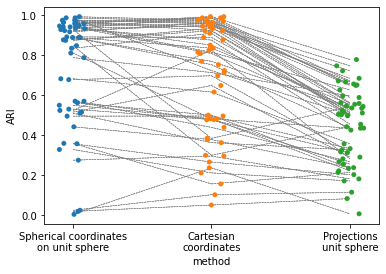

In [ ]:
# collapse 
ARI = {"ARI": ari_com, "method": "Cartesian\ncoordinates", "Simulation Number": range(1,len(ari_com)+1)}
ARI_norm =  {"ARI": ari_com_norm, "method": "Projections\nunit sphere", "Simulation Number": range(1,len(ari_com_norm)+1)}
ARI_theta = { "ARI": ari_com_theta, "method": "Spherical coordinates\non unit sphere","Simulation Number": range(1,len(ari_com_theta)+1)}

ARI = pd.DataFrame(data=ARI)
ARI_norm = pd.DataFrame(data=ARI_norm)
ARI_theta = pd.DataFrame(data=ARI_theta)
ARI = pd.concat([ARI_theta, ARI, ARI_norm], axis=0)

ax = sns.stripplot(x="method", y="ARI", data=ARI)

for idx in ARI.index:
    df =ARI.loc[idx]
    p1 = df.loc[df["method"] == "Spherical coordinates\non unit sphere"];
    p2 = df.loc[df["method"] == "Cartesian\ncoordinates"];
    p3 = df.loc[df["method"] == "Projections\nunit sphere"];
    ax.plot([0, 1], [p1["ARI"], p2["ARI"]], color = 'grey', linewidth = 0.5, linestyle = '--', zorder=-1)
    ax.plot([1, 2], [p2["ARI"], p3["ARI"]], color = 'grey', linewidth = 0.5, linestyle = '--', zorder=-1)

Looking at the ARIs plot, it appears that clustering using projections on the unit sphere is less effective for the generated networks than if utilizing cartesian and spherical coordinates. From the ARI plot it is difficult to tell which technique has produced better embeddings between clustering on spherical coordinates and on cartesian coordinates. 

To check this we compute the average of ARI scores obtained.

# Average ARI per method

In [ ]:
print(np.mean(ari_com))
print(np.std(ari_com))

0.6843354311447737
0.2850285039219778


In [ ]:
print(np.mean(ari_com_norm))
print(np.std(ari_com_norm))

0.4417084436293726
0.18744015351248372


In [ ]:
print(np.mean(ari_com_theta))
print(np.std(ari_com_theta))

0.7334426761561131
0.27734618000399075


It appears that the average ARI obtained by clusterings on cartesian coordinates is $\approx$ 0.68 with a standard deviation of $\approx$  0.28 while for the projections on the unit circle is $\approx$ 0.44 with a standard deviation of $\approx$ 0.19 and for the clusterings on spherical coordinates it is $\approx$ 0.73 with a standard deviation of $\approx$ 0.28. Therefore, for DCSBM graphs with $n = 500$ number of nodes there is not any significant difference in performance.

# ARI comparison for $n=1000$ number of nodes

We now repeat the previous experiment, this time generating $N=50$ graphs with $n=1000$ nodes and the same parameters.

$N = 50,K=3\\
| G_i | = 1000\\
G_i \sim DCSBM(B_i, \rho) \text{for }i= 1,2,...,N \\
B_i \sim Uniform(0, 1)^{K×K}\\
\rho \sim Beta(2, 1)$

In [ ]:
# collapse
## Arguments
n = 1000
M_sim = 50 
K = 3

## Set seed to repeat the simulation
np.random.seed(14444)
q = np.array([int(x) for x in np.linspace(0,n,num=K,endpoint=False)])
z = np.zeros(n,dtype=int)
for k in range(K):
    z[q[k]:] = k

n_com_1000 = []
n_com_norm_1000 = []
n_com_theta_1000 = []

ari_com_1000 = []
ari_com_norm_1000 = []
ari_com_theta_1000 = []

## Repeat M_sim times
for s in range(M_sim):
    print(s)
    B = np.tril(np.random.uniform(size=(K,K)))
    B += np.tril(B,k=-1).T

    rho = np.random.beta(a=2,b=1,size=n)
    ## Construct the adjacency matrix
    A = np.zeros((n,n))
    for i in range(n-1):
        for j in range(i+1,n):
            edge = np.random.binomial(n=1,p=rho[i]*rho[j]*B[z[i],z[j]],size=1)
            A[i,j] = edge
            A[j,i] = edge

    ## Obtain the embeddings
    ase = AdjacencySpectralEmbed(n_components=K, check_lcc=False)
    X = ase.fit_transform(A)
    
    #removes latent positions made up only by zeros
    idx_zerorows = np.where(~X.any(axis=1))
    X = np.delete(X, idx_zerorows, 0) #removes latent positions made up only by zeros
    zz = np.delete(z, idx_zerorows, 0) 

    #M = AutoGMMCluster(min_components=2, max_components=7, affinity= 'euclidean', linkage='ward', covariance_type='full')
    M = AutoGMMCluster(min_components=2, max_components=7)
    for t in [None, 'normalised', 'theta']:
      if t == 'normalised':
          M.fit(normalize(X), y=zz)
          n_com_norm_1000.append(M.n_components_)
          ari_com_norm_1000.append(M.ari_)
      elif t == 'theta':
          M.fit(theta_transform(X), y=zz)
          n_com_theta_1000.append(M.n_components_)
          ari_com_theta_1000.append(M.ari_)
      else: 
          M.fit(X, y=zz)
          n_com_1000.append(M.n_components_)
          ari_com_1000.append(M.ari_)

# Plot ARI and estimated number of communities

Let's plot the ARI obtained at each iteration.

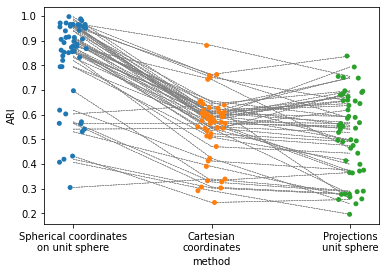

In [ ]:
# collapse 
ARI = {"ARI": ari_com, "method": "Cartesian\ncoordinates", "Simulation Number": range(1,len(ari_com)+1)}
ARI_norm =  {"ARI": ari_com_norm, "method": "Projections\nunit sphere", "Simulation Number": range(1,len(ari_com_norm)+1)}
ARI_theta = { "ARI": ari_com_theta, "method": "Spherical coordinates\non unit sphere","Simulation Number": range(1,len(ari_com_theta)+1)}

ARI = pd.DataFrame(data=ARI)
ARI_norm = pd.DataFrame(data=ARI_norm)
ARI_theta = pd.DataFrame(data=ARI_theta)
ARI = pd.concat([ARI_theta, ARI, ARI_norm], axis=0)

ax = sns.stripplot(x="method", y="ARI", data=ARI)

for idx in ARI.index:
    df =ARI.loc[idx]
    p1 = df.loc[df["method"] == "Spherical coordinates\non unit sphere"];
    p2 = df.loc[df["method"] == "Cartesian\ncoordinates"];
    p3 = df.loc[df["method"] == "Projections\nunit sphere"];
    ax.plot([0, 1], [p1["ARI"], p2["ARI"]], color = 'grey', linewidth = 0.5, linestyle = '--', zorder=-1)
    ax.plot([1, 2], [p2["ARI"], p3["ARI"]], color = 'grey', linewidth = 0.5, linestyle = '--', zorder=-1)

# Average ARI per method

In [ ]:
print(np.mean(ari_com_1000))
print(np.std(ari_com_1000))

0.5518791043531435
0.13078979233998847


In [ ]:
print(np.mean(ari_com_norm_1000))
print(np.std(ari_com_norm_1000))

0.515146898517092
0.1685139213655032


In [ ]:
print(np.mean(ari_com_theta_1000))
print(np.std(ari_com_theta_1000))

0.8150189297803873
0.1799052115754325


It appears that the average ARI obtained by clusterings on cartesian coordinates is $\approx$ 0.55 with a standard deviation of $\approx$  0.13 while for the projections on the unit circle is $\approx$ 0.52 with a standard deviation of $\approx$ 0.17 and for the clusterings on spherical coordinates it is $\approx$ 0.82 with a standard deviation of $\approx$ 0.18. Therefore, for DCSBM graphs with $n = 1000$ there seems to be a significant difference between the spherical and cartesian clusterings methods.

# Experiment with fixed B and varying number of nodes

As we have seen in the previous experiments there seems to be a difference in performance dependent upon the number of nodes. Therefore, we here fix a B matrix, and generate DCSBM graphs with different number of nodes $n_i = (100, 300, 600, 800, 1000, 1500)$ to evaluate the performance for increasing number of nodes in the graph. We generate 25 graphs for each set of nodes and repeat the clustering process for each one of them. The generative procedure is as follows:

$N = 25,K=3\\
n = \begin{bmatrix}n_1, &n_2, &n_3, &n_4, &n_5, & n_6\end{bmatrix} = \begin{bmatrix}100, &300, &600,& 800,&1000,& 1500\end{bmatrix}\\
| G_{i,j} | = n_i \text{ for }i = 1,...,6\\
G_{i,j} \sim DCSBM(B, \rho) \text{ for } j = 1,2,...,N \\
B = \begin{bmatrix} 0.8 & 0.6 & 0.45\\ 0.6 & 0.5 & 0.2 \\ 0.45 & 0.2 & 0.3\end{bmatrix}\\
\rho \sim Beta(2, 1)$

In [ ]:
n_nodes = (100, 300, 600, 800, 1000, 1500)
n_coms = []
aris_n = []
for n in n_nodes:
  B = np.vstack(([0.8, 0.6, 0.45],
                 [0.6, 0.5, 0.2],
                 [0.45, 0.2, 0.3]))
  
  n_com, aris = compare_ARIs(B,n=n, M_sim = 25, plot = False, seed = 1000)
  n_coms.append(n_com)
  aris_n.append(aris)

# Plot Results

Here we visualize the results

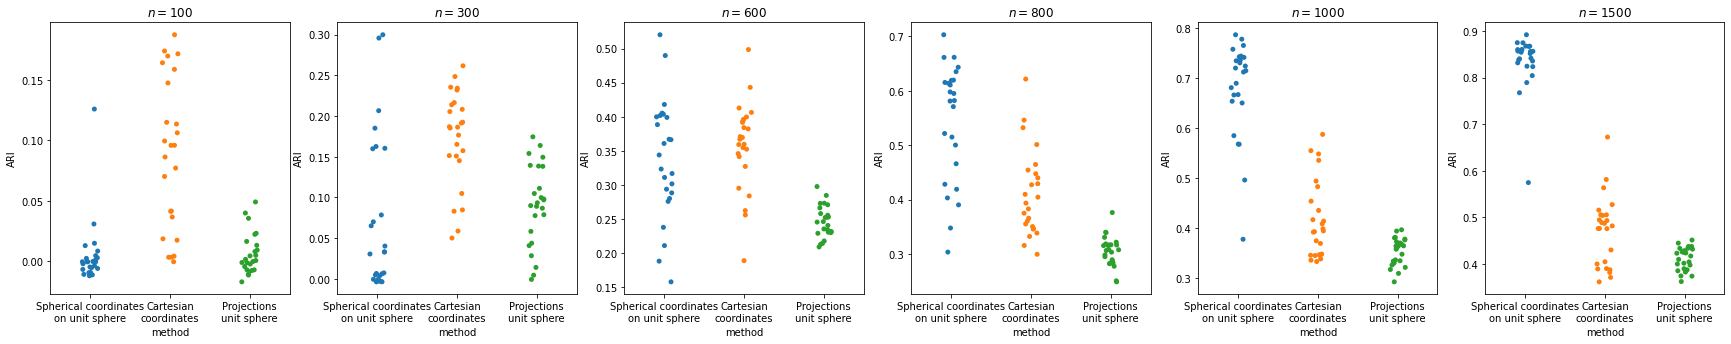

In [ ]:
# collapse
scale = 5

fig, ax = plt.subplots(1, len(n_nodes), figsize=(scale * len(n_nodes), scale * 1))

for i in range(len(n_nodes)):
  ari_com, ari_com_norm, ari_com_theta = aris_n[i][0], aris_n[i][1], aris_n[i][2]

  ARI = {"ARI": ari_com, "method": "Cartesian\ncoordinates", "Simulation Number": range(1,len(ari_com)+1)}
  ARI_norm =  {"ARI": ari_com_norm, "method": "Projections\nunit sphere", "Simulation Number": range(1,len(ari_com_norm)+1)}
  ARI_theta = { "ARI": ari_com_theta, "method": "Spherical coordinates\non unit sphere","Simulation Number": range(1,len(ari_com_theta)+1)}

  ARI = pd.DataFrame(data=ARI)
  ARI_norm = pd.DataFrame(data=ARI_norm)
  ARI_theta = pd.DataFrame(data=ARI_theta)
  ARI = pd.concat([ARI_theta, ARI, ARI_norm], axis=0)

  ax[i] = sns.stripplot(x="method", y="ARI", data=ARI, ax=ax[i])
  ax[i].set(title=r"$n = "+str(n_nodes[i])+"$")
  

As we can see, there appears to be a trend for which clusterings using spherical coordinates have increasing ARI scores as the number of nodes is increasing. Therefore, we now plot the trends of the ARIs obtained for the different methods and for different number of nodes.

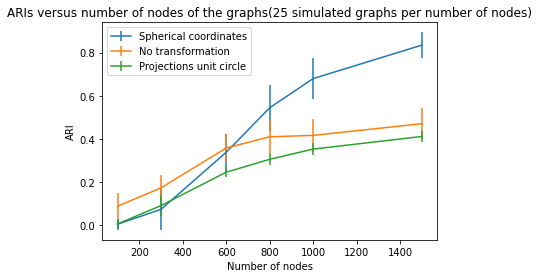

In [ ]:
# collapse
aris_n = np.array(aris_n)
ari_means = np.mean(aris_n, 2)
ari_stds = np.std(aris_n, 2)
fig, ax = plt.subplots()
ax.errorbar(n_nodes, ari_means[:, 2], yerr=ari_stds[:, 2])
ax.errorbar(n_nodes, ari_means[:, 0], yerr=ari_stds[:, 0])
ax.errorbar(n_nodes, ari_means[:, 1], yerr=ari_stds[:, 1])
ax.legend(['Spherical coordinates', 'No transformation', 'Projections unit circle'])
ax.set_title('ARIs versus number of nodes of the graphs(' + str(25) + ' simulated graphs per number of nodes)')
ax.set_xlabel('Number of nodes')
ax.set_ylabel('ARI')
plt.show()

In this plot, on the x-axis are the number of nodes of the graph and on the y-axis are the values of ARI obtained via clustering. Each data point represents the average ARI obtained across the simulated graphs per a certain number of nodes. The error bar represent one standard deviation of the ARIs obtained. 
As we can see from the plot, clusterings on spherical coordinates(colored in orange) produce greater ARI scores for increasing number of nodes compared to clusterings of the latent positions without any transformation of coordinates(colored in blue) and clusterings on the normalized latent positions(colored in green).

#Experiment with fixed B(not sparse, positive definite)

Thus far, we have been sampling graphs from DCSBM using a randomly selected $B \sim Uniform(0, 1)^{K×K}$. We now fix a $B$ matrix and repeat the same process. We first select a $B$ matrix which is positive definite and will not produce a sparse graph(each entry of $B$ is not small). We thus produce 50 graphs according to the following generative process. 

$N = 50,K=3\\
| G_i | = 1000\\
G_i \sim DCSBM(B, \rho) \text{for }i= 1,2,...,N \\
B = \begin{bmatrix} 0.45 & 0.90 & 0.95\\ 0.90 & 0.25 & 0.65 \\ 0.95 & 0.65 & 0.05\end{bmatrix}\\
\rho \sim Beta(2, 1)$

In [ ]:
B = np.vstack(([0.45, 0.90, 0.95],
               [0.90, 0.25, 0.65],
               [0.95, 0.65, 0.05]))

n_com, aris = compare_ARIs(B, M_sim = 50, plot = False)

#Plot results

We now plot the results.

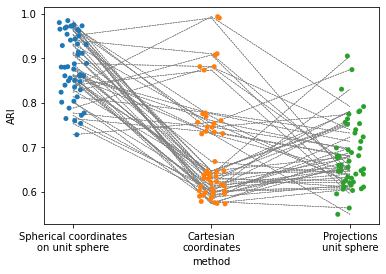

In [ ]:
# collapse
ari_com, ari_com_norm, ari_com_theta = aris[0], aris[1], aris[2]

ARI = {"ARI": ari_com, "method": "Cartesian\ncoordinates", "Simulation Number": range(1,len(ari_com)+1)}
ARI_norm =  {"ARI": ari_com_norm, "method": "Projections\nunit sphere", "Simulation Number": range(1,len(ari_com_norm)+1)}
ARI_theta = { "ARI": ari_com_theta, "method": "Spherical coordinates\non unit sphere","Simulation Number": range(1,len(ari_com_theta)+1)}

ARI = pd.DataFrame(data=ARI)
ARI_norm = pd.DataFrame(data=ARI_norm)
ARI_theta = pd.DataFrame(data=ARI_theta)
ARI = pd.concat([ARI_theta, ARI, ARI_norm], axis=0)

ax = sns.stripplot(x="method", y="ARI", data=ARI)

for idx in ARI.index:
    df =ARI.loc[idx]
    p1 = df.loc[df["method"] == "Spherical coordinates\non unit sphere"];
    p2 = df.loc[df["method"] == "Cartesian\ncoordinates"];
    p3 = df.loc[df["method"] == "Projections\nunit sphere"];
    ax.plot([0, 1], [p1["ARI"], p2["ARI"]], color = 'grey', linewidth = 0.5, linestyle = '--', zorder=-1)
    ax.plot([1, 2], [p2["ARI"], p3["ARI"]], color = 'grey', linewidth = 0.5, linestyle = '--', zorder=-1)

As we can see, the same trend of improvement of clusterings performance is maintained even for such fixed $B$ matrix.

#Experiment with fixed B(not sparse, negative definite)

We now repeat the same experiment fixing $B$ matrix but this time we select a negative definite $B$ matrix which again will not produce a sparse graph(each entry of $B$ is not small). We thus produce 50 graphs according to the following generative process. 

$N = 50,K=3\\
| G_i | = 1000\\
G_i \sim DCSBM(B, \rho) \text{for }i= 1,2,...,N \\
B = \begin{bmatrix} 0.6 & 0.5 & 0.65\\ 0.5 & 0.3 & 0.2 \\ 0.65 & 0.2 & 0.15\end{bmatrix}\\
\rho \sim Beta(2, 1)$

In [ ]:
B = np.vstack(([0.6, 0.5, 0.65],
               [0.5, 0.3, 0.2],
               [0.65, 0.2, 0.15]))

n_com, aris = compare_ARIs(B, M_sim = 50, plot=False)

#Plot results

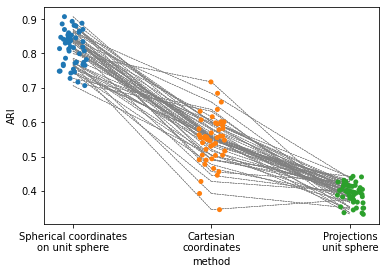

In [ ]:
# collapse
ari_com, ari_com_norm, ari_com_theta = aris[0], aris[1], aris[2]

ARI = {"ARI": ari_com, "method": "Cartesian\ncoordinates", "Simulation Number": range(1,len(ari_com)+1)}
ARI_norm =  {"ARI": ari_com_norm, "method": "Projections\nunit sphere", "Simulation Number": range(1,len(ari_com_norm)+1)}
ARI_theta = { "ARI": ari_com_theta, "method": "Spherical coordinates\non unit sphere","Simulation Number": range(1,len(ari_com_theta)+1)}

ARI = pd.DataFrame(data=ARI)
ARI_norm = pd.DataFrame(data=ARI_norm)
ARI_theta = pd.DataFrame(data=ARI_theta)
ARI = pd.concat([ARI_theta, ARI, ARI_norm], axis=0)

ax = sns.stripplot(x="method", y="ARI", data=ARI)

for idx in ARI.index:
    df =ARI.loc[idx]
    p1 = df.loc[df["method"] == "Spherical coordinates\non unit sphere"];
    p2 = df.loc[df["method"] == "Cartesian\ncoordinates"];
    p3 = df.loc[df["method"] == "Projections\nunit sphere"];
    ax.plot([0, 1], [p1["ARI"], p2["ARI"]], color = 'grey', linewidth = 0.5, linestyle = '--', zorder=-1)
    ax.plot([1, 2], [p2["ARI"], p3["ARI"]], color = 'grey', linewidth = 0.5, linestyle = '--', zorder=-1)

#Experiment by varying determinant

As it can be noted in the previous experiments, the performance of clustering seems to be robust to changes in determinant of the matrix B.

Therefore in this experiment, we try to systematically vary the determinant of the matrix B. To do so we utilize:

$B=\begin{bmatrix} 1 & 0.5 & 0.5\\ 0.5 & a & b\\ 0.5 & b & a\end{bmatrix}$.

To vary the determinant we vary the pairs $(a,b)$. 
For simplicity we pick: 
$(a, b)_1 = (0.1,1)$, $(a, b)_2 = (0.25,75)$, $(a, b)_3 = (0.5,0.5)$, $(a, b)_4 = (0.75,0.25)$, $(a, b)_5 = (1,0.1)$. For each pair, we generate 50 $DCSBM$ graphs with $\rho \sim Beta(2, 1)$ and repeat embedding plus clustering.

In [ ]:
pairs = [(0.1,1), (0.25, 0.75), (0.5,0.5),  (0.75, 0.25), (1, 0.1)]
n_coms = []
aris_det = []
for a, b in pairs:
  B = np.vstack(([1, 0.5, 0.5],
                 [0.5, a, b],
                 [0.5, b, a]))
  n_com, aris = compare_ARIs(B, M_sim = 50, plot = False)
  n_coms.append(n_com)
  aris_det.append(aris)

# Plotting Results

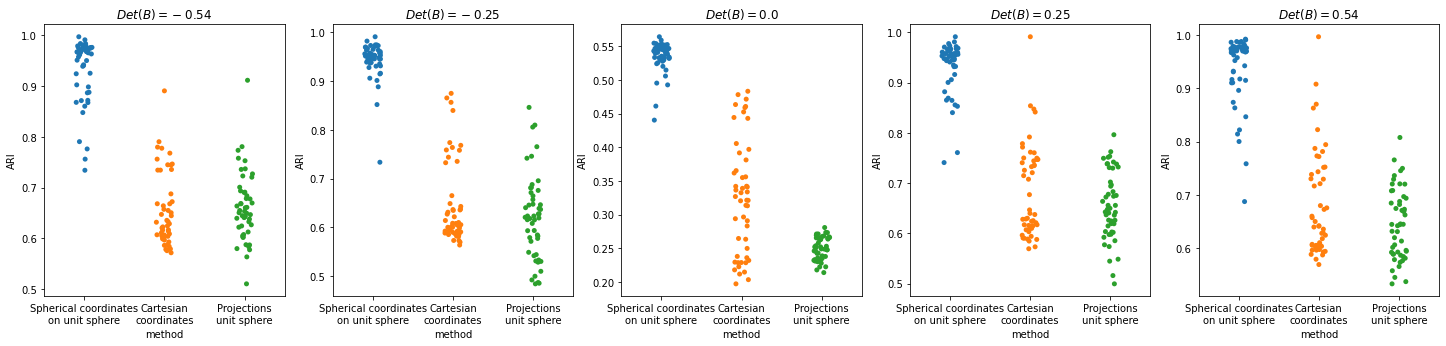

In [ ]:
# collapse
dets = []
pairs = [(0.1,1), (0.25, 0.75), (0.5,0.5),  (0.75, 0.25), (1, 0.1)]
for a, b in pairs:
  B = np.vstack(([1, 0.5, 0.5],
                 [0.5, a, b],
                 [0.5, b, a]))
  dets.append(np.linalg.det(B))

scale = 5

fig, ax = plt.subplots(1, 5, figsize=(scale * 5, scale * 1))

for i in range(5):
  ari_com_1000, ari_com_norm_1000, ari_com_theta_1000 = aris_det[i][0], aris_det[i][1], aris_det[i][2]

  ARI = {"ARI": ari_com_1000, "method": "Cartesian\ncoordinates", "Simulation Number": range(1,len(ari_com_1000)+1)}
  ARI_norm =  {"ARI": ari_com_norm_1000, "method": "Projections\nunit sphere", "Simulation Number": range(1,len(ari_com_norm_1000)+1)}
  ARI_theta = { "ARI": ari_com_theta_1000, "method": "Spherical coordinates\non unit sphere","Simulation Number": range(1,len(ari_com_theta_1000)+1)}

  ARI = pd.DataFrame(data=ARI)
  ARI_norm = pd.DataFrame(data=ARI_norm)
  ARI_theta = pd.DataFrame(data=ARI_theta)
  ARI = pd.concat([ARI_theta, ARI, ARI_norm], axis=0)

  ax[i] = sns.stripplot(x="method", y="ARI", data=ARI, ax=ax[i])
  ax[i].set(title=r"$Det(B) = "+str(round(dets[i],2))+"$")

As highlighted by the previous figure the improvement of performance appears to be unaffected by changes in determinant of the matrix B. Indeed, even when the determinant is equal to zero and almost all entries are equal to 0.5, despite seeing an expected decrease in ARI scores obtained(since now groups 2 and 3 have identical latent positions), spherical clustering still appears to perform better than the other methods, implying that even in scenarios in which the noise(off-diagonal probabilities) is identical to the signal(diagonal entries of B) spherical clusterings seems to be able to better recover the signal than if using other methods.

# Experiment with fixed B(diagonal, not fully connected)

Thus far, we have been focusing on fully connected graphs. However, how does the performance change if the graph is not fully connected? To test this out we perform an experiment on a DCSBM simulated from a diagonal $B$ matrix. Again, we repeat the same process as for the other experiments, generating 50 graphs, performing embedding and finally clustering the latent positions. The generative process is as follows:

$N = 50,K=3\\
| G_i | = 1000\\
G_i \sim DCSBM(B, \rho) \text{for }i= 1,2,...,N \\
B = \begin{bmatrix} 0.8 & 0.0 & 0.0\\ 0.0 & 0.3 & 0.0 \\ 0.0 & 0.0 & 0.15\end{bmatrix}\\
\rho \sim Beta(2, 1)$

In [ ]:
B = np.vstack(([0.8, 0, 0],
               [0, 0.5, 0],
               [0, 0, 0.2]))

n_com, aris = compare_ARIs(B, M_sim = 50, plot = False)

# Plot Results

Here we plot the results

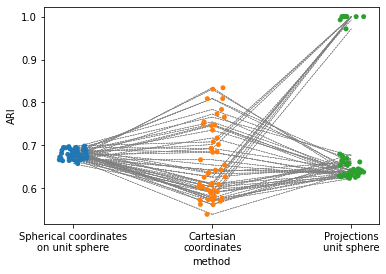

In [ ]:
# collapse
ari_com, ari_com_norm, ari_com_theta = aris[0], aris[1], aris[2]

ARI = {"ARI": ari_com, "method": "Cartesian\ncoordinates", "Simulation Number": range(1,len(ari_com)+1)}
ARI_norm =  {"ARI": ari_com_norm, "method": "Projections\nunit sphere", "Simulation Number": range(1,len(ari_com_norm)+1)}
ARI_theta = { "ARI": ari_com_theta, "method": "Spherical coordinates\non unit sphere","Simulation Number": range(1,len(ari_com_theta)+1)}

ARI = pd.DataFrame(data=ARI)
ARI_norm = pd.DataFrame(data=ARI_norm)
ARI_theta = pd.DataFrame(data=ARI_theta)
ARI = pd.concat([ARI_theta, ARI, ARI_norm], axis=0)

ax = sns.stripplot(x="method", y="ARI", data=ARI)

for idx in ARI.index:
    df =ARI.loc[idx]
    p1 = df.loc[df["method"] == "Spherical coordinates\non unit sphere"];
    p2 = df.loc[df["method"] == "Cartesian\ncoordinates"];
    p3 = df.loc[df["method"] == "Projections\nunit sphere"];
    ax.plot([0, 1], [p1["ARI"], p2["ARI"]], color = 'grey', linewidth = 0.5, linestyle = '--', zorder=-1)
    ax.plot([1, 2], [p2["ARI"], p3["ARI"]], color = 'grey', linewidth = 0.5, linestyle = '--', zorder=-1)

Interestingly, clusterings of embeddings of not fully connected graphs produce models with ARI scores with very low variance for embeddings in spherical coordinates. On the other hand, ARI scores obtained on clusterings in cartesian coordinates seem to be centered around the same mean $\approx 0.7$ but have greater variance. 

# Experiment by varying sparsity

Now that we have checked how the methods compare when the graphs utilized are not fully connected, we would like to explore how does the performance change across varying sparsity levels of the graph. To do so, we progressively reduce the probabilities values of B by scaling each entry by a sparsity parameter. As for previous experiments, we do so by selecting a list of sparsity parameters, $\phi_i$, to use and for each one of them generate 50 graphs, perform embedding and clusterings using the different methodologies and finally plot the results. The generative process is as follows:

$N = 50,K=3\\
 \Phi = \begin{bmatrix}\phi_1, &\phi_2, &\phi_3, &\phi_4, &\phi_5\end{bmatrix} = \begin{bmatrix}1, &5, &10,& 20,&40\end{bmatrix}\\
| G_{i,j} | = 1000\\
G_{i,j} \sim DCSBM(\frac{B}{\phi_i}, \rho) \text{ for }i = 1,...,5\text{ and for } j = 1,2,...,N \\
B = \begin{bmatrix} 0.8 & 0.6 & 0.45\\ 0.6 & 0.5 & 0.2 \\ 0.45 & 0.2 & 0.3\end{bmatrix}\\
\rho \sim Beta(2, 1)$


In [ ]:
sparsity_params = (1, 5, 10, 20, 40)
n_coms = []
aris_sparse = []
for rho in sparsity_params:
  B = np.vstack(([0.9, 0.2, 0.2],
                 [0.2, 0.7, 0.2],
                 [0.2, 0.2, 0.5]))
  
  B = B / rho
  n_com, aris = compare_ARIs(B, M_sim = 50, plot=False, seed=2000)
  n_coms.append(n_com)
  aris_sparse.append(aris)

# Plot Results

Here we plot the results.

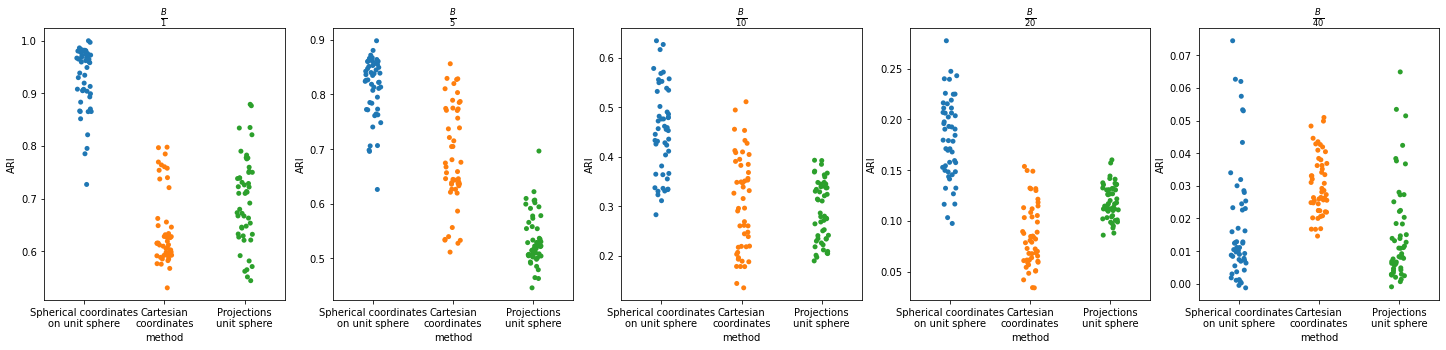

In [ ]:
# collapse
scale = 5

fig, ax = plt.subplots(1, 5, figsize=(scale * 5, scale * 1))

for i in range(5):
  ari_com_1000, ari_com_norm_1000, ari_com_theta_1000 = aris_sparse[i][0], aris_sparse[i][1], aris_sparse[i][2]

  ARI = {"ARI": ari_com_1000, "method": "Cartesian\ncoordinates", "Simulation Number": range(1,len(ari_com_1000)+1)}
  ARI_norm =  {"ARI": ari_com_norm_1000, "method": "Projections\nunit sphere", "Simulation Number": range(1,len(ari_com_norm_1000)+1)}
  ARI_theta = { "ARI": ari_com_theta_1000, "method": "Spherical coordinates\non unit sphere","Simulation Number": range(1,len(ari_com_theta_1000)+1)}

  ARI = pd.DataFrame(data=ARI)
  ARI_norm = pd.DataFrame(data=ARI_norm)
  ARI_theta = pd.DataFrame(data=ARI_theta)
  ARI = pd.concat([ARI_theta, ARI, ARI_norm], axis=0)

  ax[i] = sns.stripplot(x="method", y="ARI", data=ARI, ax=ax[i])
  ax[i].set(title=r"$\frac{B}{"+str(sparsity_params[i])+"}$")

As we can see from the figure, clusterings on spherical coordinates seems to  maintain increased performance across varying sparsity level of the graphs. To formalize this we produce the following plot.

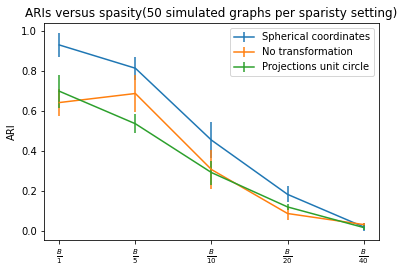

In [ ]:
# collapse
aris_n = np.array(aris_sparse)
ari_means = np.mean(aris_sparse, 2)
ari_stds = np.std(aris_sparse, 2)
fig, ax = plt.subplots()
ax.errorbar(range(5), ari_means[:, 2], yerr=ari_stds[:, 2])
ax.errorbar(range(5), ari_means[:, 0], yerr=ari_stds[:, 0])
ax.errorbar(range(5), ari_means[:, 1], yerr=ari_stds[:, 1])
ax.legend(['Spherical coordinates', 'No transformation', 'Projections unit circle'])
ax.set_title('ARIs versus spasity(' + str(50) + ' simulated graphs per sparisty setting)')
ax.set_xticks((0, 1, 2, 3, 4))
ax.set_xticklabels((r'$\frac{B}{1}$',r'$\frac{B}{5}$', r'$\frac{B}{10}$', r'$\frac{B}{20}$', r'$\frac{B}{40}$'))
ax.set_ylabel('ARI')
plt.show()

In this plot, on the x-axis are the B matrices scaled by the sparsity parameter and on the y-axis are the value of ARIs obtained via clustering. Each data point represents the average ARI obtained across the simulated graphs per sparsity level. The error bar represents one standard deviation of the ARIs obtained. 
As we can see from the plot, clusterings on spherical coordinates(colored in orange) produce greater ARI scores for increasing sparsity of the same graph compared to clusterings of the latent positions without any transformation of coordinates(colored in blue) and for clusterings on the normalized latent positions(colored in green). Therefore, spherical clusterings appear to be more robust to increasing sparsity of the same graph.

# Observations/notes

- Spherical clusterings of DCSBM latent positions, appears to outperform other methods across varying sparsity levels, and varying B matrix structure for graphs with number of nodes greater than $\approx 500$.
- There does not appear to be a big difference in performance for smaller graphs (number of nodes less than $\approx 500$).
- Surprisingly, normalized latent positions seems to be outperformed across all experiments by other methods.